<p align="center"><img src="https://raw.githubusercontent.com/IntelRealSense/librealsense/master/doc/img/realsense.png" width="70%" /></p>

## Introduction

Simple tutorial we will take to start working


## The Tools
We are planning to use the following packages:

In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import math
import time
print("Environment Ready")

Environment Ready


In [2]:
# Configure depth and color streams
pipe = rs.pipeline()
cfg = rs.config()
import platform

if platform.system() == "Windows":
    cfg.enable_device_from_file("object_detection.bag")
else:
    # Get device product line for setting a supporting resolution
    pipeline_wrapper = rs.pipeline_wrapper(pipe)
    pipeline_profile = cfg.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    device_product_line = str(device.get_info(rs.camera_info.product_line))

    found_rgb = False
    for s in device.sensors:
        if s.get_info(rs.camera_info.name) == 'RGB Camera':
            found_rgb = True
            break
    if not found_rgb:
        print("The demo requires Depth camera with Color sensor")
        exit(0)

    cfg.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

    if device_product_line == 'L500':
        cfg.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
    else:
        cfg.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)



In [3]:
def project(v):
    """project 3d vector array to 2d"""
    h, w = out.shape[:2]
    view_aspect = float(h)/w

    # ignore divide by zero for invalid depth
    with np.errstate(divide='ignore', invalid='ignore'):
        proj = v[:, :-1] / v[:, -1, np.newaxis] * \
            (w*view_aspect, h) + (w/2.0, h/2.0)

    # near clipping
    znear = 0.03
    proj[v[:, 2] < znear] = np.nan
    return proj


def view(v):
    """apply view transformation on vector array"""
    return v


def line3d(out, pt1, pt2, color=(0x80, 0x80, 0x80), thickness=1):
    """draw a 3d line from pt1 to pt2"""
    p0 = project(pt1.reshape(-1, 3))[0]
    p1 = project(pt2.reshape(-1, 3))[0]
    if np.isnan(p0).any() or np.isnan(p1).any():
        return
    p0 = tuple(p0.astype(int))
    p1 = tuple(p1.astype(int))
    rect = (0, 0, out.shape[1], out.shape[0])
    inside, p0, p1 = cv2.clipLine(rect, p0, p1)
    if inside:
        cv2.line(out, p0, p1, color, thickness, cv2.LINE_AA)


def grid(out, pos, rotation=np.eye(3), size=1, n=10, color=(0x80, 0x80, 0x80)):
    """draw a grid on xz plane"""
    pos = np.array(pos)
    s = size / float(n)
    s2 = 0.5 * size
    for i in range(0, n+1):
        x = -s2 + i*s
        line3d(out, view(pos + np.dot((x, 0, -s2), rotation)),
               view(pos + np.dot((x, 0, s2), rotation)), color)
    for i in range(0, n+1):
        z = -s2 + i*s
        line3d(out, view(pos + np.dot((-s2, 0, z), rotation)),
               view(pos + np.dot((s2, 0, z), rotation)), color)


def axes(out, pos, rotation=np.eye(3), size=0.075, thickness=2):
    """draw 3d axes"""
    line3d(out, pos, pos +
           np.dot((0, 0, size), rotation), (0xff, 0, 0), thickness)
    line3d(out, pos, pos +
           np.dot((0, size, 0), rotation), (0, 0xff, 0), thickness)
    line3d(out, pos, pos +
           np.dot((size, 0, 0), rotation), (0, 0, 0xff), thickness)


def frustum(out, intrinsics, color=(0x40, 0x40, 0x40)):
    """draw camera's frustum"""
    orig = view([0, 0, 0])
    w, h = intrinsics.width, intrinsics.height

    for d in range(1, 6, 2):
        def get_point(x, y):
            p = rs.rs2_deproject_pixel_to_point(intrinsics, [x, y], d)
            line3d(out, orig, view(p), color)
            return p

        top_left = get_point(0, 0)
        top_right = get_point(w, 0)
        bottom_right = get_point(w, h)
        bottom_left = get_point(0, h)

        line3d(out, view(top_left), view(top_right), color)
        line3d(out, view(top_right), view(bottom_right), color)
        line3d(out, view(bottom_right), view(bottom_left), color)
        line3d(out, view(bottom_left), view(top_left), color)


def pointcloud(out, verts, texcoords, color, painter=True):
    """draw point cloud with optional painter's algorithm"""
    if painter:
        # Painter's algo, sort points from back to front

        # get reverse sorted indices by z (in view-space)
        # https://gist.github.com/stevenvo/e3dad127598842459b68
        v = view(verts)
        s = v[:, 2].argsort()[::-1]
        proj = project(v[s])
    else:
        proj = project(view(verts))


    h, w = out.shape[:2]

    # proj now contains 2d image coordinates
    j, i = proj.astype(np.uint32).T

    # create a mask to ignore out-of-bound indices
    im = (i >= 0) & (i < h)
    jm = (j >= 0) & (j < w)
    m = im & jm

    cw, ch = color.shape[:2][::-1]
    if painter:
        # sort texcoord with same indices as above
        # texcoords are [0..1] and relative to top-left pixel corner,
        # multiply by size and add 0.5 to center
        v, u = (texcoords[s] * (cw, ch) + 0.5).astype(np.uint32).T
    else:
        v, u = (texcoords * (cw, ch) + 0.5).astype(np.uint32).T
    # clip texcoords to image
    np.clip(u, 0, ch-1, out=u)
    np.clip(v, 0, cw-1, out=v)

    # perform uv-mapping
    out[i[m], j[m]] = color[u[m], v[m]]



## The API
Next, we will open depth and RGB streams from pre-recorded file and capture a set of frames:


In [4]:
profile = pipe.start(cfg)
# Get stream profile and camera intrinsics
depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
colorizer = rs.colorizer()

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

mapped_frame= color_frame

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

color_source = color_image

points = pc.calculate(depth_frame)
pc.map_to(mapped_frame)
        # Pointcloud data to arrays
v, t = points.get_vertices(), points.get_texture_coordinates()
verts = np.asanyarray(v).view(np.float32).reshape(-1, 3)  # xyz
texcoords = np.asanyarray(t).view(np.float32).reshape(-1, 2)  # uv

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## Point Cloud Data
We extracting point cloud

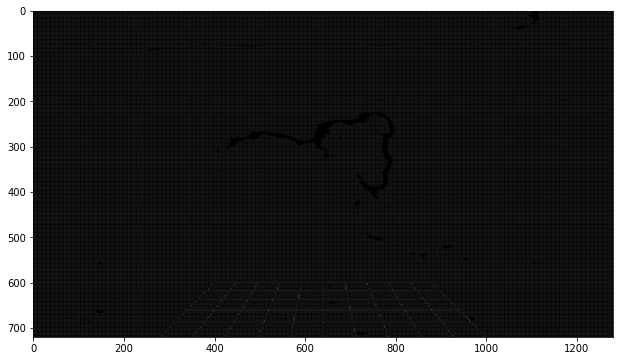

In [13]:
out = np.empty((h, w, 3), dtype=np.uint8)
now = time.time()

out.fill(0)

grid(out, (0, 0.5, 1), size=1, n=10)
#frustum(out, depth_intrinsics)
# (out, view([0, 0, 0]), rotation=np.eye(3), size=0.1, thickness=1)
tmp = np.zeros((h, w, 3), dtype=np.uint8)
pointcloud(out, verts, texcoords, color_source)

color = np.asanyarray(out)
#lt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]

plt.rcParams["figure.facecolor"] = "white"  # Set background color
plt.rcParams["axes.facecolor"] = "white"  # Set background color

#lt.grid(color='gray', linestyle='dotted', linewidth=0.5)  # Add gridlines

plt.imshow(color)

In [43]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the bag filename
bag_filename = "object_detection.bag"

# Configure the pipeline
pipe = rs.pipeline()
config = rs.config()
config.enable_device_from_file(bag_filename)
pipe.start(config)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
    pipe.wait_for_frames()

# Wait for the next frame
frameset = pipe.wait_for_frames()
# Extract the depth and color frames
depth_frame = frameset.get_depth_frame()
color_frame = frameset.get_color_frame()

# Create point cloud from depth image
pcd = rs.pointcloud()
points = pcd.calculate(depth_frame)

# Get the point cloud vertices as numpy array
vertices = np.asarray(points.get_vertices()).view(np.float32).reshape(-1, 3)

pipe.stop()

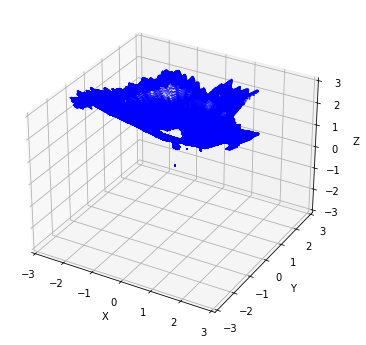

In [44]:

# Visualize the point cloud using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c="b", s=0.1)

s =3
# Set the limits of the plot axes to zoom in by a factor of 50
ax.set_xlim(s*-1, s)
ax.set_ylim(s*-1, s)
ax.set_zlim(s*-1, s)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()



In [ ]:
import open3d as o3d
# Create an Open3D PointCloud from the numpy array
pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(vertices)

# Visualize the point cloud
o3d.visualization.draw_geometries([pointcloud])

## RGB Data
Let's start with accessing the color componnent of the frameset:

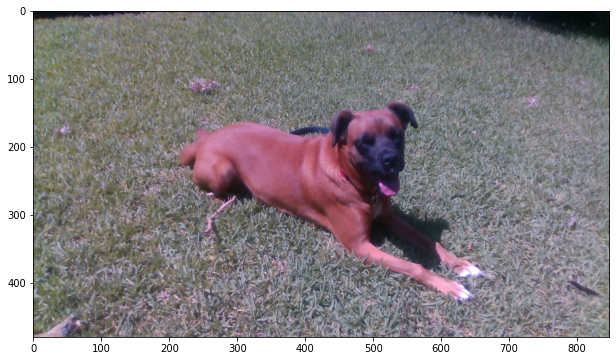

In [20]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

## Depth Data
Now, we will visualize the depth map captured by the RealSense camera:

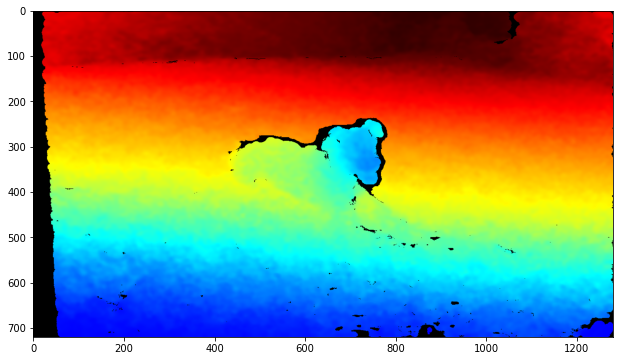

In [19]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Stream Alignment
Upon closer inspection you can notice that the two frames are not captured from the same physical viewport.

To combine them into a single RGBD image, let's align depth data to color viewport:

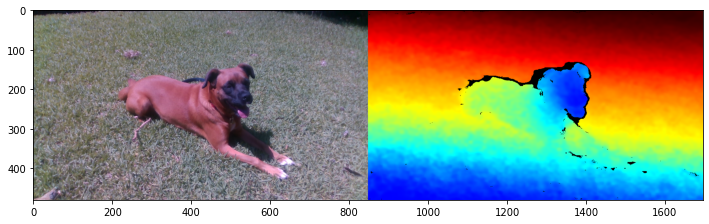

In [11]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

Now the two images are pixel-perfect aligned and you can use depth data just like you would any of the other channels.

## Object Detection

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and use additional depth data to enrich our prediction.

In [ ]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt", "MobileNetSSD_deploy.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

By projecting this data into the depth channel, we can now answer additional questions we couldn't approach before.

For example, with computer vision only it would be rather hard to make any meaningful predictions about **size and distance**.
You could train a model on average dog size per breed, but it would be easily fooled by toys of dogs or dogs of irregular proportions. Instead you can get this information directly when you have depth available!

Let's project our detected bounding box on to the depth image, and average the depth data inside it to get a sense of how close is the object:

In [ ]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [ ]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

This is a rather simple example, but it gives you a taste of what can be accomplished by combining depth with modern computer vision.

> **Want to learn more?** Visit [realsense.intel.com](http://realsense.intel.com) and [github.com/IntelRealSense](http://www.github.com/IntelRealSense/librealsense)